In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [2]:
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"),flavor='html5lib')[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-03-24,8901.95,8996.18,8665.70,8668.12,5664600000,150762000000
1,2018-03-23,8736.25,8879.62,8360.62,8879.62,5954120000,147941000000
2,2018-03-22,8939.44,9100.71,8564.90,8728.47,5530390000,151366000000
3,2018-03-21,8937.48,9177.37,8846.33,8929.28,6043130000,151316000000
4,2018-03-20,8619.67,9051.02,8389.89,8913.47,6361790000,145922000000


In [3]:
# get market info for ethereum from the start of 2016 to the current day
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"),flavor='html5lib')[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# look at the first few rows
eth_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-03-24,542.57,545.38,526.08,526.44,1300010000,53375400000
1,2018-03-23,539.86,540.49,512.13,539.62,1596350000,53098100000
2,2018-03-22,562.10,577.57,523.09,539.70,1523460000,55273800000
3,2018-03-21,559.10,589.61,550.57,561.73,1781270000,54967300000
4,2018-03-20,556.72,567.09,521.20,557.17,1833680000,54722100000


In [4]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

In [5]:

market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2016-01-01']
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
0,2018-03-24,8901.95,8996.18,8665.70,8668.12,5664600000,150762000000,542.57,545.38,526.08,526.44,1300010000,53375400000,-0.026267,-0.029729
1,2018-03-23,8736.25,8879.62,8360.62,8879.62,5954120000,147941000000,539.86,540.49,512.13,539.62,1596350000,53098100000,0.016411,-0.000445
2,2018-03-22,8939.44,9100.71,8564.90,8728.47,5530390000,151366000000,562.10,577.57,523.09,539.70,1523460000,55273800000,-0.023600,-0.039851
3,2018-03-21,8937.48,9177.37,8846.33,8929.28,6043130000,151316000000,559.10,589.61,550.57,561.73,1781270000,54967300000,-0.000917,0.004704
4,2018-03-20,8619.67,9051.02,8389.89,8913.47,6361790000,145922000000,556.72,567.09,521.20,557.17,1833680000,54722100000,0.034085,0.000808


In [6]:
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

In [7]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_', 'eth_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
813,2016-01-01,434.33,36278900,-0.560641,0.020292,0.948024,206062,-0.418477,0.025040
812,2016-01-02,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913
811,2016-01-03,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792
810,2016-01-04,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943
809,2016-01-05,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236


In [8]:
#Training / Test Set Split

In [9]:
split_date = '2017-06-01'
training_set, test_set = model_data[model_data["Date"]<split_date], model_data[model_data['Date']>= split_date]
training_set = training_set.drop('Date',1)
test_set = test_set.drop('Date',1)

In [10]:
training_set.head()

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
813,434.33,36278900,-0.560641,0.020292,0.948024,206062,-0.418477,0.025040
812,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913
811,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792
810,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943
809,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236


In [28]:
#Window settings for timeseries analysis
window_len=10
cols_train = training_set.columns
cols_test = training_set.columns
norm_cols = [coin+metric for coin in ['bt_','eth_'] for metric in ['Close','Volume']]
output_cols = [coin+metric for coin in ['bt_','eth_'] for metric in ['Close']]

cols_train_ex_norm  = list(filter(lambda x: x not in norm_cols,cols_train))
cols_test_ex_norm  = list(filter(lambda x: x not in norm_cols,cols_test))

In [29]:
#Create normalized windows: training

LSTM_training_inputs=[]
LSTM_training_outputs=[]
for i in range(len(training_set)-window_len):
    temp_window=training_set[i:(i+window_len)]
    temp_set_in = pd.concat([temp_window[cols_train_ex_norm],(temp_window[norm_cols]/temp_window[norm_cols].iloc[0] -1)],axis=1)
    LSTM_training_inputs.append(temp_set_in.fillna(0.0))

In [65]:
LSTM_training_outputs_bt = (training_set[output_cols[0]][window_len:].values/training_set[output_cols[0]][:-window_len].values)-1
LSTM_training_outputs_eth = (training_set[output_cols[1]][window_len:].values/training_set[output_cols[1]][:-window_len].values)-1

In [71]:
print(LSTM_training_inputs[0],len(LSTM_training_inputs))
print(LSTM_training_outputs_bt[0],len(LSTM_training_outputs_bt))

     bt_close_off_high  bt_volatility  eth_close_off_high  eth_volatility  \
813          -0.560641       0.020292           -0.418477        0.025040   
812           0.250597       0.009641            0.965898        0.034913   
811          -0.173865       0.020827           -0.317885        0.060792   
810          -0.474265       0.012649           -0.057657        0.047943   
809          -0.013333       0.010391            0.697930        0.025236   
808          -0.003623       0.012782           -0.214540        0.026263   
807          -0.951499       0.069045            0.681644        0.040587   
806           0.294196       0.032762           -0.806717        0.055274   
805           0.814194       0.017094           -0.411897        0.019021   
804          -0.919598       0.017758           -0.938235        0.025266   

     bt_Close  bt_Volume  eth_Close  eth_Volume  
813  0.000000   0.000000   0.000000    0.000000  
812 -0.002049  -0.170410  -0.011498    0.239937  
81

In [72]:
#Create normalized windows: training

LSTM_test_inputs=[]
LSTM_test_outputs=[]
for i in range(len(test_set)-window_len):
    temp_window=test_set[i:(i+window_len)]
    temp_set_in = pd.concat([temp_window[cols_test_ex_norm],(temp_window[norm_cols]/temp_window[norm_cols].iloc[0] -1)],axis=1)
    LSTM_test_inputs.append(temp_set_in.fillna(0.0))

In [79]:
LSTM_test_outputs_bt = (test_set[output_cols[0]][window_len:].values/test_set[output_cols[0]][:-window_len].values)-1
LSTM_test_outputs_eth = (test_set[output_cols[1]][window_len:].values/test_set[output_cols[1]][:-window_len].values)-1

In [81]:
print(LSTM_test_inputs[0],len(LSTM_test_inputs))
print(LSTM_test_outputs_bt[0],len(LSTM_test_outputs_bt))

     bt_close_off_high  bt_volatility  eth_close_off_high  eth_volatility  \
296          -0.493815       0.069946            0.286109        0.094157   
295          -1.000000       0.047932            0.145473        0.044222   
294          -0.159278       0.063496           -0.514504        0.029312   
293           0.111061       0.052339           -0.615588        0.117928   
292          -1.000000       0.070287           -0.685358        0.026176   
291          -0.115346       0.114860           -0.705854        0.083146   
290           0.625637       0.058835            0.241769        0.040226   
289          -0.865882       0.053060           -0.859903        0.032094   
288           0.468564       0.037789           -0.902903        0.080267   
287          -0.967912       0.072288           -0.631062        0.242013   

     bt_Close  bt_Volume  eth_Close  eth_Volume  
296  0.000000   0.000000   0.000000    0.000000  
295  0.033503  -0.203335   0.006929   -0.422416  
29

In [83]:
#convert to numpy arrays
LSTM_training_inputs_np = np.array([np.array(tr_inp) for tr_inp in LSTM_training_inputs])
LSTM_training_outputs_bt_np = LSTM_training_outputs_bt
LSTM_training_outputs_eth_np = LSTM_training_outputs_eth
print(LSTM_training_inputs_np.shape) # days,window size, columns
print(LSTM_training_outputs_np.shape)

(507, 10, 8)
(507, 2)


In [84]:
#convert to numpy arrays
LSTM_test_inputs_np = np.array([np.array(te_inp) for te_inp in LSTM_test_inputs])
LSTM_test_outputs_bt_np = LSTM_test_outputs_bt
LSTM_test_outputs_eth_np = LSTM_test_outputs_eth
print(LSTM_test_inputs_np.shape) # days,window size, columns
print(LSTM_test_outputs_np.shape)

(287, 10, 8)
(287, 2)


# LSTM

In [22]:

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


###  ETH Train

In [86]:
# random seed for reproducibility
np.random.seed(42)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs_np, output_size=1, neurons = 20)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs_np, LSTM_training_outputs_eth_np, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)


Epoch 1/50
3s - loss: 0.1550
Epoch 2/50
2s - loss: 0.1086
Epoch 3/50
2s - loss: 0.0982
Epoch 4/50
2s - loss: 0.0894
Epoch 5/50
2s - loss: 0.0889
Epoch 6/50
2s - loss: 0.0833
Epoch 7/50
2s - loss: 0.0821
Epoch 8/50
2s - loss: 0.0809
Epoch 9/50
2s - loss: 0.0760
Epoch 10/50
2s - loss: 0.0786
Epoch 11/50
2s - loss: 0.0727
Epoch 12/50
2s - loss: 0.0787
Epoch 13/50
2s - loss: 0.0725
Epoch 14/50
2s - loss: 0.0722
Epoch 15/50
2s - loss: 0.0715
Epoch 16/50
2s - loss: 0.0742
Epoch 17/50
2s - loss: 0.0717
Epoch 18/50
2s - loss: 0.0728
Epoch 19/50
2s - loss: 0.0678
Epoch 20/50
2s - loss: 0.0685
Epoch 21/50
2s - loss: 0.0682
Epoch 22/50
2s - loss: 0.0666
Epoch 23/50
2s - loss: 0.0680
Epoch 24/50
2s - loss: 0.0652
Epoch 25/50
2s - loss: 0.0698
Epoch 26/50
2s - loss: 0.0682
Epoch 27/50
2s - loss: 0.0717
Epoch 28/50
2s - loss: 0.0648
Epoch 29/50
2s - loss: 0.0674
Epoch 30/50
2s - loss: 0.0691
Epoch 31/50
2s - loss: 0.0687
Epoch 32/50
2s - loss: 0.0615
Epoch 33/50
2s - loss: 0.0680
Epoch 34/50
2s - lo

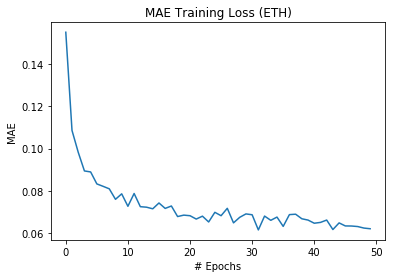

In [87]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(eth_history.epoch,eth_history.history['loss'])
ax1.set_title("MAE Training Loss (ETH)")
ax1.set_xlabel('# Epochs')
ax1.set_ylabel('MAE')

plt.show()

###  ETH Predict

#### On Train Data

In [91]:
eth_train_predict = np.transpose(eth_model.predict(LSTM_training_inputs_np))
